### Introduction

Each bag contains a collection of molecular fragments. The label is the sum of some property calculated for each fragment. These properties are chosen to be preferably additive (can be calculated as a linear contribution of each fragment). The predicted weights should correspond to the contribution of each fragment. The higher the contribution, the higher the weight should be.

**Instance:** One molecular fragment (e.g. C(=O)O - Carboxy group).

**Bag**: A collection of fragments (e.g., a list of 5 fragments).

**Label:** A sum of fragment property value (e.g. LogP) in the bag.

**Key instance:** All fragments.

In [1]:
import torch
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# Fragments dataset creation
from rdkit import Chem
from rdkit.Chem import AllChem
from qsarmil.data.fragment import create_fragment_bags
from qsarmil.mil.network.module.utils import set_seed

# MIL regressors
from qsarmil.mil.network.regressor import (AttentionNetworkRegressor,
                                           TempAttentionNetworkRegressor,
                                           GatedAttentionNetworkRegressor,
                                           MultiHeadAttentionNetworkRegressor,
                                           SelfAttentionNetworkRegressor,
                                           HopfieldAttentionNetworkRegressor,
                                           DynamicPoolingNetworkRegressor)

# Utils
from scipy.stats import spearmanr
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from qsarmil.mil.preprocessing import BagMinMaxScaler

# Prediction visualisation
from qsarmil.data.fragment import display_fragments_with_weights

# RDKit warnings
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

### Key Instance Detection Ranking Accuracy for Regression

This function evaluates how well a model's predicted attention weights rank the important instances in a bag, by computing the Spearman rank correlation between:

* The true importance ranking (represented here by the fragment property values)

* The predicted importance scores (predicted weights)

In [2]:
def kid_ranking_accuracy(instance_digits, attn_weights):

    per_bag_corrs = []
    for w, digits in zip(attn_weights, instance_digits):
        if len(set(digits)) == 1:
            # Avoid undefined correlation when all digits are identical
            per_bag_corrs.append(0.0)
            continue

        corr, _ = spearmanr(w, digits)
        if np.isnan(corr):
            corr = 0.0
        per_bag_corrs.append(corr)

    mean_corr = np.mean(per_bag_corrs)
    return mean_corr

### 1. Create Fragment dataset

In Multiple Instance Learning (MIL), each bag is a collection of instances (here, molecular fragments), and the task often involves predicting a label for the entire bag. In this specific setup:

* Each molecule is broken into BRICS fragments.

* A fixed number of these fragments are randomly sampled to form a bag.

* A chemical property is calculated for each fragment.

* The sum of fragment properties becomes the bag's label.

* The function returns: The fragment bags (as RDKit Mol objects), The bag labels (total property), The individual fragment properties (per bag).

**The list of properties that can be calculated for fragments:**

* ``LogP`` – Lipophilicity

* ``MolWt`` – Molecular weight

* ``TPSA`` – Topological polar surface area

* ``NumHDonors`` – Number of hydrogen bond donors

* ``NumHAcceptors`` – Number of hydrogen bond acceptors

* ``MolMR`` – Molar refractivity

* ``NumRotatableBonds`` – Flexibility

* ``RingCount`` – Number of rings

* ``FractionCSP3`` – Fraction of sp³-hybridized carbon atoms

In [3]:
bag_size = 5
property_name = "LogP"

smiles = list(pd.read_csv("data/CHEMBL1824/train.csv", header=None)[0])
mols = [Chem.MolFromSmiles(s) for s in smiles]

# create dataset
bags, labels, contribs = create_fragment_bags(mols, bag_size=bag_size, property_name=property_name)

In [4]:
print(f"Total number of molecules: {len(mols)}")
print(f"Total number of bags (successfully generated fragments): {len(bags)}")

Total number of molecules: 1667
Total number of bags (successfully generated fragments): 1234


In [5]:
bags[0]

In [6]:
contribs[0]

[0.4608, 0.029899999999999982, 0.9216, -0.0684, 0.4121199999999999]

### 2. Calculate fragment descriptors

In [7]:
def compute_fragment_descriptors(bags, n_bits=128, radius=2):
    bags_descriptors = []
    for bag in bags:
        descs = [np.array(AllChem.GetMorganFingerprintAsBitVect(frag, radius, nBits=n_bits))
                 for frag in bag]
        bags_descriptors.append(descs)
    return bags_descriptors

In [8]:
dsc = compute_fragment_descriptors(bags)

### 3. Build model

In [9]:
network_hparams = {'hidden_layer_sizes':(256, 128, 64),
                   'num_epoch':300,
                   'batch_size':128,
                   'learning_rate':0.001,
                   'weight_decay':0.001,
                   'instance_weight_dropout':0.01,
                   'init_cuda':False,
                   'verbose':False}

In [10]:
x_train, x_test, y_train, y_test, key_train, key_test, frg_train, frg_test = train_test_split(dsc, labels, contribs, bags, random_state=42)

In [11]:
scaler = BagMinMaxScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [12]:
model = DynamicPoolingNetworkRegressor(**network_hparams)
model.to("cpu")
model.fit(x_train_scaled, y_train)

DynamicPoolingNetworkRegressor(
  (extractor): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
  )
  (pooling): DynamicPooling()
  (estimator): Norm()
)

In [13]:
y_pred = model.predict(x_test_scaled)
w_pred = model.get_instance_weights(x_test_scaled)

In [14]:
print(f"Regression R2: {r2_score(y_test, y_pred):.2f}")
print(f"KID ranking accuracy: {kid_ranking_accuracy(key_test, w_pred):.2f}")

Regression R2: 0.65
KID ranking accuracy: 0.85


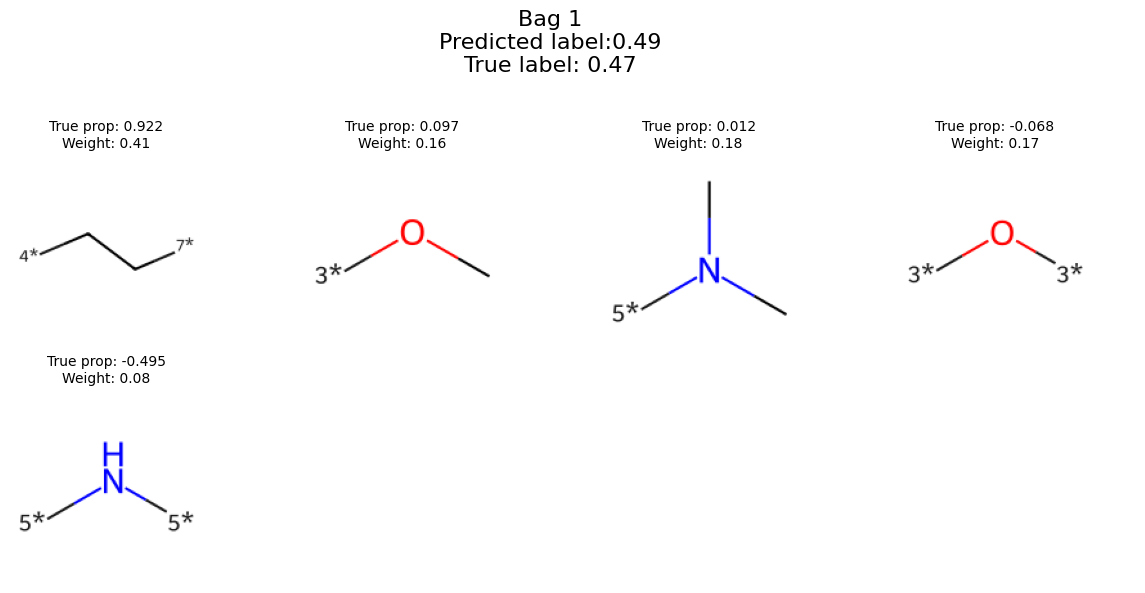

In [15]:
N = 1
display_fragments_with_weights(frg_test[N], key_test[N], w_pred[N], sort=True, max_fragments=10,
                               title=f"Bag {N}\nPredicted label:{y_pred[N].item():.2f}\nTrue label: {y_test[N]:.2f}")

### 4. KID benchmark

In [16]:
network_hparams = {'hidden_layer_sizes':(256, 128, 64),
                   'num_epoch':300,
                   'batch_size':128,
                   'learning_rate':0.001,
                   'weight_decay':0.001,
                   'instance_weight_dropout':0.01,
                   'init_cuda':False,
                   'verbose':False}

In [17]:
network_list = [
                ("AttentionNetworkRegressor", AttentionNetworkRegressor(**network_hparams)), 
                ("TempAttentionNetworkRegressor", TempAttentionNetworkRegressor(**network_hparams, tau=0.5)), 
                ("GatedAttentionNetworkRegressor", GatedAttentionNetworkRegressor(**network_hparams)), 
                ("MultiHeadAttentionNetworkRegressor", MultiHeadAttentionNetworkRegressor(**network_hparams, num_heads=10)), 
                ("SelfAttentionNetworkRegressor", SelfAttentionNetworkRegressor(**network_hparams)), 
                ("HopfieldAttentionNetworkRegressor", HopfieldAttentionNetworkRegressor(**network_hparams, beta=1)),
                ("DynamicPoolingNetworkRegressor", DynamicPoolingNetworkRegressor(**network_hparams)),
               ]

In [19]:
bag_size = 5

res_df = pd.DataFrame()
tasks = ["LogP", "MolWt", "TPSA", "NumHDonors", "NumHAcceptors", 
         "MolMR", "NumRotatableBonds", "RingCount", "FractionCSP3"]

for task_idx, task in enumerate(tasks, 1):
    print(f"\n[Task {task_idx}/{len(tasks)}] Starting task: '{task}'")

    # create data
    smiles = list(pd.read_csv("data/CHEMBL1824/train.csv", header=None)[0])
    mols = [Chem.MolFromSmiles(s) for s in smiles]
    
    bags, labels, contribs = create_fragment_bags(mols, bag_size=bag_size, property_name=task)
    dsc = compute_fragment_descriptors(bags)
    
    x_train, x_test, y_train, y_test, key_train, key_test, frg_train, frg_test = train_test_split(
        dsc, labels, contribs, bags, random_state=42)
    
    # scale features
    scaler = BagMinMaxScaler()
    scaler.fit(x_train)
    x_train_scaled, x_test_scaled = scaler.transform(x_train), scaler.transform(x_test)
    
    # build models
    for model_idx, (name, model) in enumerate(network_list, 1):
        print(f"  [Model {model_idx}/{len(network_list)}] Training model: '{name}'")

        # train model
        model.to("cpu")
        model.fit(x_train_scaled, y_train)
        
        # predict
        y_pred = model.predict(x_test_scaled)
        w_pred = model.get_instance_weights(x_test_scaled)
        #
        res_df.loc[name, f"PRED_{task}"] = r2_score(y_test, y_pred)
        res_df.loc[name, f"KID_{task}"] = kid_ranking_accuracy(key_test, w_pred)

print("\nAll tasks and models completed.")


[Task 1/9] Starting task: 'LogP'
  [Model 1/7] Training model: 'AttentionNetworkRegressor'
  [Model 2/7] Training model: 'TempAttentionNetworkRegressor'
  [Model 3/7] Training model: 'GatedAttentionNetworkRegressor'
  [Model 4/7] Training model: 'MultiHeadAttentionNetworkRegressor'
  [Model 5/7] Training model: 'SelfAttentionNetworkRegressor'
  [Model 6/7] Training model: 'HopfieldAttentionNetworkRegressor'
  [Model 7/7] Training model: 'DynamicPoolingNetworkRegressor'

[Task 2/9] Starting task: 'MolWt'
  [Model 1/7] Training model: 'AttentionNetworkRegressor'
  [Model 2/7] Training model: 'TempAttentionNetworkRegressor'


/tmp/ipykernel_2271426/4149945887.py:10: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = spearmanr(w, digits)


  [Model 3/7] Training model: 'GatedAttentionNetworkRegressor'
  [Model 4/7] Training model: 'MultiHeadAttentionNetworkRegressor'
  [Model 5/7] Training model: 'SelfAttentionNetworkRegressor'
  [Model 6/7] Training model: 'HopfieldAttentionNetworkRegressor'
  [Model 7/7] Training model: 'DynamicPoolingNetworkRegressor'

[Task 3/9] Starting task: 'TPSA'
  [Model 1/7] Training model: 'AttentionNetworkRegressor'
  [Model 2/7] Training model: 'TempAttentionNetworkRegressor'
  [Model 3/7] Training model: 'GatedAttentionNetworkRegressor'
  [Model 4/7] Training model: 'MultiHeadAttentionNetworkRegressor'
  [Model 5/7] Training model: 'SelfAttentionNetworkRegressor'
  [Model 6/7] Training model: 'HopfieldAttentionNetworkRegressor'
  [Model 7/7] Training model: 'DynamicPoolingNetworkRegressor'

[Task 4/9] Starting task: 'NumHDonors'
  [Model 1/7] Training model: 'AttentionNetworkRegressor'
  [Model 2/7] Training model: 'TempAttentionNetworkRegressor'
  [Model 3/7] Training model: 'GatedAttentio

In [20]:
res_df.round(2)

,PRED_LogP,KID_LogP,PRED_MolWt,KID_MolWt,PRED_TPSA,KID_TPSA,PRED_NumHDonors,KID_NumHDonors,PRED_NumHAcceptors,KID_NumHAcceptors,PRED_MolMR,KID_MolMR,PRED_NumRotatableBonds,KID_NumRotatableBonds,PRED_RingCount,KID_RingCount,PRED_FractionCSP3,KID_FractionCSP3
AttentionNetworkRegressor,0.89,0.19,0.91,0.26,0.86,-0.19,0.84,0.62,0.94,-0.02,0.94,-0.95,0.91,0.34,0.98,-0.13,0.98,0.02
TempAttentionNetworkRegressor,0.87,0.04,0.90,-0.86,0.85,-0.27,0.84,0.62,0.89,-0.09,0.94,-0.39,0.91,0.34,0.98,-0.00,0.98,0.18
GatedAttentionNetworkRegressor,0.90,0.06,0.90,-0.93,0.85,-0.02,0.85,0.62,0.94,-0.01,0.94,-0.25,0.93,0.34,0.97,-0.11,0.98,-0.28
MultiHeadAttentionNetworkRegressor,0.89,0.32,0.92,-0.01,0.88,-0.04,0.86,0.62,0.95,0.88,0.95,-0.41,0.94,0.33,0.98,0.85,0.99,0.01
SelfAttentionNetworkRegressor,0.89,-0.84,0.43,-0.57,0.56,0.82,0.86,0.62,0.95,-0.46,0.46,0.81,0.94,-0.34,0.98,-0.73,0.98,0.81
HopfieldAttentionNetworkRegressor,0.83,0.03,0.40,0.81,0.49,0.72,0.70,0.42,0.58,0.22,0.47,0.91,0.78,0.26,0.97,-0.01,0.98,0.15
DynamicPoolingNetworkRegressor,0.66,0.85,0.84,0.89,0.83,0.91,0.79,0.62,0.82,0.88,0.88,0.96,0.83,0.34,0.96,0.85,0.91,0.78
